## Лабороторная работа №5 по курсу ТМО
## "Линейные модели, SVM и деревья решений".
**Цель лабораторной работы**: изучение линейных моделей, SVM и деревьев решений.

In [1]:
import numpy as np
import pandas as pd
from sklearn.externals.six import StringIO 
from IPython.display import Image
import graphviz
from typing import Dict, Tuple
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

c:\python_3.7.4\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


### 1. Выбор набора данных
Для решения задачи регрессии выберем набор данных [Daily Temperature of Major Cities](https://www.kaggle.com/sudalairajkumar/daily-temperature-of-major-cities), который показывает среднесуточные значения температуры воздуха зафиксированы в крупных городах мира.

In [2]:
data = pd.read_csv('../datasets/city_temperature.csv')
data

c:\python_3.7.4\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9
...,...,...,...,...,...,...,...,...
2906322,North America,US,Additional Territories,San Juan Puerto Rico,7,27,2013,82.4
2906323,North America,US,Additional Territories,San Juan Puerto Rico,7,28,2013,81.6
2906324,North America,US,Additional Territories,San Juan Puerto Rico,7,29,2013,84.2
2906325,North America,US,Additional Territories,San Juan Puerto Rico,7,30,2013,83.8


In [3]:
data.shape

(2906327, 8)

In [4]:
data.dtypes

Region             object
Country            object
State              object
City               object
Month               int64
Day                 int64
Year                int64
AvgTemperature    float64
dtype: object

### 2. Удаление пропусков и кодирование признаков

Проверим наличие пропусков в данных:

In [5]:
data.isnull().sum()

Region                  0
Country                 0
State             1450990
City                    0
Month                   0
Day                     0
Year                    0
AvgTemperature          0
dtype: int64

In [6]:
# удалим колонку state, тк штаты есть не во всех странах и нам этот прзнак не особо важен в понятийном смысле
data = data.dropna(axis=1, how='any')
data.shape

(2906327, 7)

In [7]:
# пропусков в данных нет
data.isnull().sum()

Region            0
Country           0
City              0
Month             0
Day               0
Year              0
AvgTemperature    0
dtype: int64

Так как мы имеем очень много строк, то будем решать более узкую задачу и возьмем данные только за 2013 год.

In [8]:
data = data[data['Year']==2013]
data.shape

(111021, 7)

In [9]:
data = data.drop(['Year'], axis=1)

Кодирование категориальных признаков:

In [10]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [11]:
#label encoding
le = LabelEncoder()
reg_enc_le = le.fit_transform(data['Region'])
country_enc_le = le.fit_transform(data['Country'])
city_enc_le = le.fit_transform(data['City'])

In [12]:
data_new = data.drop(['Region','Country','City','AvgTemperature'], axis=1)
data_new['Region'] = reg_enc_le
data_new['Country'] = country_enc_le
data_new['City'] = city_enc_le
data_new['AvgTemperature'] = data['AvgTemperature']
data_new

,Month,Day,Region,Country,City,AvgTemperature
6575,1,1,0,1,7,49.2
6576,1,2,0,1,7,51.7
6577,1,3,0,1,7,48.2
6578,1,4,0,1,7,49.2
6579,1,5,0,1,7,49.4
...,...,...,...,...,...,...
2906322,7,27,5,103,244,82.4
2906323,7,28,5,103,244,81.6
2906324,7,29,5,103,244,84.2
2906325,7,30,5,103,244,83.8


In [13]:
# one-hot encoding
ohe = OneHotEncoder()
reg_enc_ohe = ohe.fit_transform(data[['Region']])
country_enc_ohe = ohe.fit_transform(data[['Country']])
city_enc_ohe = ohe.fit_transform(data[['City']])

In [14]:
data_ohe = data.drop(['Region','Country','City','AvgTemperature'], axis=1)
data_ohe['Region'] = reg_enc_ohe
data_ohe['Country'] = country_enc_ohe
data_ohe['City'] = city_enc_ohe
data_ohe['AvgTemperature'] = data['AvgTemperature']

### 3. Разделение выборки на обучающую и тестовую

In [15]:
X = data_new[['Month','Day','Region', 'Country', 'City']]
y = data_new['AvgTemperature']
print(X.head(), "\n")
print(y.head())

      Month  Day  Region  Country  City
6575      1    1       0        1     7
6576      1    2       0        1     7
6577      1    3       0        1     7
6578      1    4       0        1     7
6579      1    5       0        1     7 

6575    49.2
6576    51.7
6577    48.2
6578    49.2
6579    49.4
Name: AvgTemperature, dtype: float64


In [16]:
from sklearn.preprocessing import StandardScaler

In [17]:
# промасштабируем X
columns = X.columns
scaler = StandardScaler()
X = scaler.fit_transform(X)
pd.DataFrame(X, columns=columns).describe()

,Month,Day,Region,Country,City
count,1.110210e+05,1.110210e+05,1.110210e+05,1.110210e+05,1.110210e+05
mean,6.912081e-18,5.056059e-17,2.048024e-16,-2.785313e-16,-1.454097e-16
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00
min,-1.600388e+00,-1.673511e+00,-2.092386e+00,-2.252290e+00,-1.726359e+00
25%,-7.300681e-01,-8.777078e-01,-4.659704e-01,-8.074637e-01,-8.622675e-01
50%,1.402518e-01,3.178103e-02,6.183069e-01,7.240526e-01,1.824264e-03
75%,1.010572e+00,8.275838e-01,6.183069e-01,7.240526e-01,8.659160e-01
max,1.590785e+00,1.737073e+00,1.160446e+00,1.013018e+00,1.706965e+00


In [18]:
# разделим выборку
temp_X_train, temp_X_test, temp_y_train, temp_y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### 4. Обучение моделей

**4.1 Обучение линейной модели**

Будем использовать класс SGDRegressor для регрессии, тк у нас больше 100K записей.

In [19]:
reg1 = SGDRegressor().fit(temp_X_train, temp_y_train)
(reg1.coef_, reg1.intercept_)

(array([ 2.33253543, -0.11671783, -3.25185886, -0.38904675, -0.7493386 ]),
 array([59.35065356]))

Посчитаем метрику:

In [20]:
print("MAE:", mean_absolute_error(temp_y_test, reg1.predict(temp_X_test)))
print("MSE:", mean_squared_error(temp_y_test, reg1.predict(temp_X_test)))

MAE: 16.69142796270563
MSE: 529.9328719252568


**4.2 Метод опорных векторов**

Будем использовать методы SVR и LinearSVR.

In [21]:
svr = SVR()
svr.fit(temp_X_train, temp_y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [22]:
linearsvr = LinearSVR()
linearsvr.fit(temp_X_train, temp_y_train)

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0)

In [23]:
print("MAE для SVR:", mean_absolute_error(temp_y_test, svr.predict(temp_X_test)))
print("MAE для LinearSVR:", mean_absolute_error(temp_y_test, linearsvr.predict(temp_X_test)))

MAE для SVR: 10.924877804330587
MAE для LinearSVR: 16.360140819897463


In [24]:
print("MSE для SVR:", mean_squared_error(temp_y_test, svr.predict(temp_X_test)))
print("MSE для LinearSVR:", mean_squared_error(temp_y_test, linearsvr.predict(temp_X_test)))

MSE для SVR: 365.9837139063695
MSE для LinearSVR: 545.3450540801515


**4.3 Дерево решений**

Для решения задачи регрессии используется класс DecisionTreeRegressor.

In [25]:
tree = DecisionTreeRegressor(random_state=1)
tree.fit(temp_X_train, temp_y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=1, splitter='best')

In [26]:
print("MAE:", mean_absolute_error(temp_y_test, tree.predict(temp_X_test)))
print("MSE:", mean_squared_error(temp_y_test, tree.predict(temp_X_test)))

MAE: 4.853039855888314
MSE: 195.76183078135557


#### Сравнение метрик
*Модель дерева решений* показала наименьшее среднее абсолютное отклонение (MAE = 4,85) и наименьшее среднеквадратичное отклонение (MSE = 195,76).
Худший показатель MAE = 16,78 у линейной модели, а худший показатель MSE = 546,16 у метода LinearSVR, основанного на методе опорных векторов.

### Визуальзация дерева решений

In [29]:
import pydotplus

In [30]:
# Визуализация дерева
def get_png_tree(tree_model_param, feature_names_param):
    dot_data = StringIO()
    export_graphviz(tree_model_param, out_file=dot_data, feature_names=feature_names_param,
                    filled=True, rounded=True, special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph.create_png()

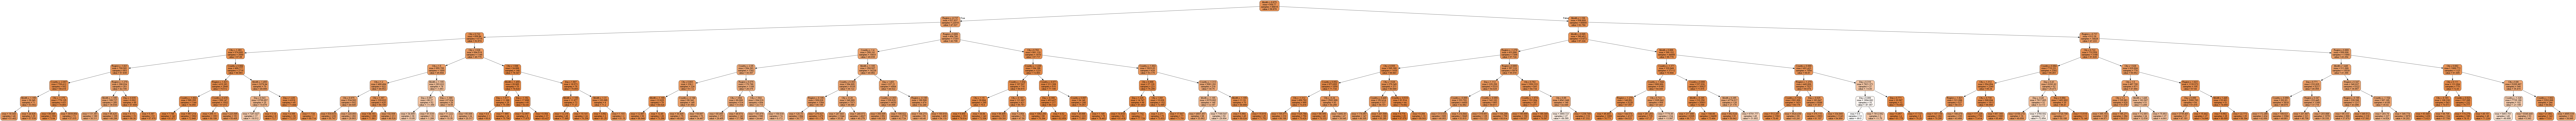

In [31]:
tree0 = DecisionTreeRegressor(random_state=1, max_depth=7)
tree0.fit(temp_X_train, temp_y_train)
Image(get_png_tree(tree0, data_new[['Month','Day','Region', 'Country', 'City']].columns), height="500")

In [32]:
tree1 = DecisionTreeRegressor(random_state=1, max_depth=3)
tree1.fit(temp_X_train, temp_y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=1, splitter='best')

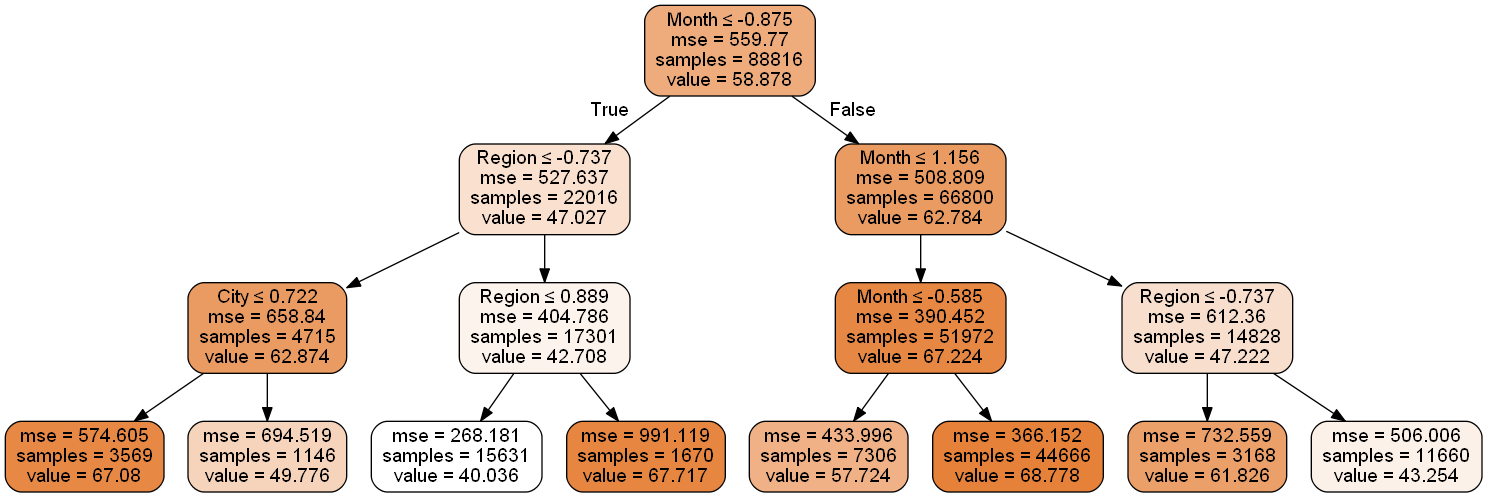

In [33]:
Image(get_png_tree(tree1, data_new[['Month','Day','Region', 'Country', 'City']].columns), height="500")

In [34]:
# Важность признаков tree1
list(zip(data_new[['Month','Day','Region', 'Country', 'City']].columns.values, tree0.feature_importances_))

[('Month', 0.47573602889183914),
 ('Day', 0.028921128272840716),
 ('Region', 0.2185495818264754),
 ('Country', 0.10038844035148292),
 ('City', 0.17640482065736185)]